# 利用SqueezeNet结构训练cumt数据
## 2017年11月8日

In [1]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload
import pickle
import tensorflow as tf
import numpy as np
from cumt_eye import Cumt_itraker
import matplotlib.pyplot as plt
import cv2
from Cumt_SqueezeNet import squeezenet
init=tf.global_variables_initializer()

sess=tf.InteractiveSession()
cumt_data=np.load('cumt_data.pkl')
index=np.arange(cumt_data['data'].shape[0])
np.random.shuffle(index)
data=cumt_data['data'][index]
label=cumt_data['labels'][index]
del cumt_data

#cumt rgb 相片均值
cumt_picmean=[103.939, 116.779, 123.68]

#### 将图片从 （32,128,3）转换成（128,128,3），有可能会导致精度下降，非必要


In [ ]:
resize_img=[]
for i in range(data.shape[0]):
    img=data[i]+cumt_picmean
    img=cv2.resize(img.astype('uint8'),(128,128))
    resize_img.append(img.astype('uint8'))
    if i%10000==0:
        print (i)
data=None
resize_img=np.array(resize_img).astype('uint8')

#### 常规设置占位符，训练节点等

In [ ]:
with tf.name_scope('PlaceHolder'):
    X=tf.placeholder(shape=[None,128,128,3],dtype=tf.float32)
    Y=tf.placeholder(shape=[None,10],dtype=tf.float32)
    LR=tf.placeholder(dtype=tf.float32)
with tf.name_scope('model'):
    model=squeezenet(X,sess)
    y_score=model.score
with tf.name_scope('LOSS'):
    LOSS=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_score,labels=Y))
    tf.summary.scalar('loss',LOSS)
with tf.name_scope('TRAIN'):
    TRAIN=tf.train.AdamOptimizer(LR).minimize(LOSS)
with tf.name_scope('ACCURACY'):
    acc_count=tf.equal(tf.arg_max(y_score,1),tf.arg_max(Y,1))
    ACCURACY=tf.reduce_mean(tf.cast(acc_count,tf.float32))
    tf.summary.scalar('acc',ACCURACY)
writer_tr=tf.summary.FileWriter('./mylog/squeezenet_32/train')
writer_te=tf.summary.FileWriter('./mylog/squeezenet_32/test',sess.graph)
writer_val=tf.summary.FileWriter('./mylog/squeezenet_32/val')
merge=tf.summary.merge_all()

#### train,test,val数据生成

In [ ]:
data=resize_img

index=np.arange(data.shape[0])
np.random.shuffle(index)
# tr_index=index[:100]
# te_index=index[100:200]
tr_index=index[:int(data.shape[0]*0.9)]
te_index=index[int(data.shape[0]*0.9):]
tr_data,tr_label=data[tr_index],label[tr_index]
te_data,te_label=data[te_index],label[te_index]
del data
del label
del resize_img
print(tr_data.shape,te_data.shape)


val_d=np.load('valimg1k_1109.pkl')
val_data=[]
for v in range(val_d['data'].shape[0]):
    img_=cv2.resize(val_d['data'][v],(128,128))
    
    val_data.append(img_)
val_data=np.array(val_data)
val_label=val_d['label']
del val_d
print(val_data.shape)

#### 开始训练

In [ ]:
init=tf.global_variables_initializer()
sess.run(init)
saver=tf.train.Saver()

In [ ]:
#model.extract_network_weight('squeezenet_669.pkl')
model.init_network('squeezenet_795.pkl')

In [ ]:
import time

In [ ]:
#5k each hour
batchsize=82
#warm up,先过拟合一个小数据集，使得网络有一个比较好的初始权值(解决网络难收敛问题)
s_time=time.time()
for j in range(1000):
    mask=np.random.choice(100,64,replace=False)
    x_,y_=tr_data[mask]-cumt_picmean,tr_label[mask]
    feed_dict={X:x_,Y:y_,LR:1e-3}
    sess.run(TRAIN,feed_dict=feed_dict)
    if j%10==0:
        feed_dict={X:x_,Y:y_}
        loss_,acc_,m_=sess.run([LOSS,ACCURACY,merge],feed_dict=feed_dict)
        #writer_tr.add_summary(m_,i)
        print('warm up,epoch:{},train loss:{},train accuracy:{}'.format(j,loss_,acc_))
        if acc_>0.9:
            print('warm up ready!time eslape:{}'.format(time.time()-s_time))
            break

#开始正式训练
lr_=1e-3
bestval_acc=0.7
for i in range(1,1000*6*12):
    mask=np.random.choice(tr_data.shape[0],batchsize,replace=False)
    x_,y_=tr_data[mask]-cumt_picmean,tr_label[mask]
    feed_dict={X:x_,Y:y_,LR:lr_}
    sess.run(TRAIN,feed_dict=feed_dict)
    if i%10==0:
        feed_dict={X:x_,Y:y_}
        loss_,acc_,m_=sess.run([LOSS,ACCURACY,merge],feed_dict=feed_dict)
        writer_tr.add_summary(m_,i)
        print('epoch:{},train loss:{},train accuracy:{}'.format(i,loss_,acc_))
    if i%20==0:
        mask=np.random.choice(te_data.shape[0],batchsize,replace=False)
        x_,y_=te_data[mask]-cumt_picmean,te_label[mask]
        feed_dict={X:x_,Y:y_}
        loss_,acc_,m_=sess.run([LOSS,ACCURACY,merge],feed_dict=feed_dict)
        writer_te.add_summary(m_,i)
        print('--epoch:{},test loss:{},test accuracy:{}'.format(i,loss_,acc_))
    if i%30==0:
        mask=np.random.choice(val_data.shape[0],128,replace=False)
        x_,y_=val_data[mask]-cumt_picmean,val_label[mask]
        feed_dict={X:x_,Y:y_}
        loss_,acc_,m_=sess.run([LOSS,ACCURACY,merge],feed_dict=feed_dict)
        writer_val.add_summary(m_,i)
        print('@@epoch:{},val loss:{},val accuracy:{}'.format(i,loss_,acc_))
        if acc_>bestval_acc+0.1:
            bestval_acc=acc_
            model_name=r'./model_save/SqueezeNet/model_'+str(int(acc_*10000))+'.ckpt'
            saver.save(sess,model_name,global_step=i)
            print('!!!!!model save!!!!!')
    if i%1000==0:
        lr_*=0.9
        lr_=max(lr_,1e-6)
        print('epoch:{},learning rate change:{}'.format(i,lr_))

In [ ]:
#保存模型
saver=tf.train.Saver()
saver.save(sess,'./model_save/SqueezeNet/model_984.ckpt',global_step=i)

In [ ]:
saver=tf.train.Saver()
#model_984.ckpt-34925
#model_8437.ckpt-1020
saver.restore(sess,r'D:\Proj_DL\Code\Proj_EyeTraker\Proj_iTraker\CUMT_iTraker\model_save\SqueezeNet\model_984.ckpt-34925')

#### 测试在验证集上的平均正确率，并提取权值保存

In [ ]:

acc_lis=[]
for k in range(100):
    mask=np.random.choice(val_data.shape[0],128,replace=False)
    x_,y_=val_data[mask]-cumt_picmean,val_label[mask]
    feed_dict={X:x_,Y:y_}
    acc_=sess.run(ACCURACY,feed_dict=feed_dict)
    acc_lis.append(acc_)
    #print(acc_)
print('acc mean:')
np.mean(acc_lis)

In [ ]:
n=list(tf.trainable_variables())
model_d={}
for k in n:
    #变量名称
    a=str(k).split("'")[1][:-2]
    print(a)
    with tf.variable_scope('',reuse=True):
        var=tf.get_variable(a)
        model_d[a]=var.eval()
        print(tf.shape(var).eval())

# fp=open('squeezenet_795.pkl','wb')
# pickle.dump(obj=model_d,file=fp)
# fp.close()

#### 将4X4眼部预测图像截取眼部，与标签一起保存

In [1]:
import pickle
import tensorflow as tf
import numpy as np
from cumt_eye import Cumt_itraker
import matplotlib.pyplot as plt
import cv2
from Cumt_SqueezeNet import squeezenet

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')  

In [3]:
def geteyeimg(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    faces = face_cascade.detectMultiScale(gray, 1.3,5) 
    if len(faces) !=1:
#         print(len(faces))
#         print('bad faces')
        return None
    for (x,y,w,h) in faces: 
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) 
            roi_gray = gray[y:y+h, x:x+w] 
            roi_color = img[y:y+h, x:x+w] 
            #检测视频中脸部的眼睛，并用vector保存眼睛的坐标、大小（用矩形表示） 
            eyes = eye_cascade.detectMultiScale(roi_gray,scaleFactor=1.2, minNeighbors=7, minSize=(29, 29),
                                     flags=cv2.CASCADE_SCALE_IMAGE) 
            #眼睛检测 ,对于识别比较差的情况舍弃
            if len(eyes)!=2:
#                 print(len(eyes))
#                 print('bad eyes')
                return None
            if eyes[0][0]>eyes[1][0]:
                ex=eyes[1][0]
                W=eyes[0][0]-eyes[1][0]+eyes[0][2]
            else:
                ex=eyes[0][0]
                W=eyes[1][0]-eyes[0][0]+eyes[1][2]
            
            if eyes[0][1]>eyes[1][1]:
                ey=eyes[1][1]
                H=eyes[0][1]-eyes[1][1]+eyes[0][3]
            else:
                ey=eyes[0][1]
                H=eyes[1][1]-eyes[0][1]+eyes[1][3]
    
    return roi_color[ey+10:ey+H-2,ex-10:ex+W+10] if roi_color is not None else None

In [4]:
import os

In [5]:
#img_dir=r'D:\Proj_DL\Code\Proj_EyeTraker\Proj_iTraker\Transfer_iTraker\img4X4_val'
img_dir=r'D:/Proj_DL/Code/Proj_EyeTraker/Proj_iTraker/CUMT_iTraker/img6x6'
eye_lis,label_lis=[],[]
fail_counter=0
c=0
for addr_ in os.listdir(img_dir):
    c+=1
    if c>500:break
    label_id=int(addr_[:-4].split('_')[-1])
    label_=[0]*36
    label_[label_id]=1
    img_=cv2.imread(os.path.join(img_dir,addr_))
    eyes_=geteyeimg(img_)
    if eyes_ is None:
        fail_counter+=1
        print(fail_counter)
        continue
    eyes_=cv2.resize(eyes_,(128,128))
    eye_lis.append(eyes_[:,:,::-1])
    label_lis.append(label_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


In [6]:
eye_lis=np.array(eye_lis)
label_lis=np.array(label_lis)
print(eye_lis.shape,label_lis.shape)

(374, 128, 128, 3) (374, 36)


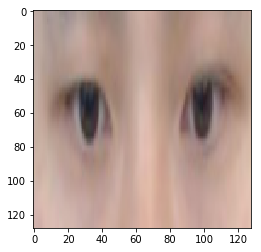

In [7]:
plt.imshow(eye_lis[0]);plt.show()

In [8]:
index_=np.arange(eye_lis.shape[0])
np.random.shuffle(index_)
eye_lis=eye_lis[index_]
label_lis=label_lis[index_]

In [9]:
ld={}
for i,l in enumerate(label_lis):
    index_=np.argmax(l)
    if not index_ in ld:
        ld[index_]=[]
    ld[index_].append(i)
for k in ld:
    print(k,len(ld[k]))

0 14
1 10
2 9
3 11
4 12
5 12
6 11
7 11
8 9
9 14
10 12
11 12
12 11
13 10
14 10
15 12
16 12
17 11
18 12
19 9
20 8
21 10
22 13
23 13
24 12
25 7
26 8
27 11
28 11
29 10
30 9
31 8
32 5
33 9
34 7
35 9


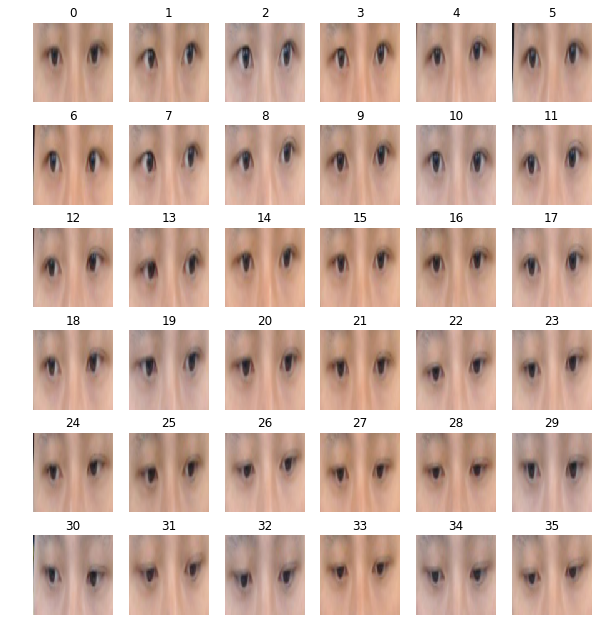

In [20]:
fig=plt.figure(figsize=(10,11))
for i in range(1,37):
    index_=ld[i-1][0]
    plt.subplot(6,6,i)
    plt.imshow(eye_lis[index_])
    plt.title(np.argmax(label_lis[index_]))
    plt.axis('off')
plt.savefig('asd.jpg')
plt.show()

In [11]:
fp=open('image_pklfile/img6X6_8951.pkl','wb')
pickle.dump(obj={'data':eye_lis,'label':label_lis},file=fp)
fp.close()

**计算所有可训练参数的数量**

In [ ]:

def get_trainable_variables_nums()
    sum_=0
    for s in list(tf.trainable_variables()):
        s=str(s)
        shape_=s[s.index('(')+1:s.index(')')].split(',')
        s_=1
        #print(shape_)
        for i in shape_:
            if i =='':continue
            #print(i)
            s_*=int(i)
        sum_+=s_
    print('trainable variables nums:{}'.format(sum_))

# 2017年11月12日10:45:39
# 利用CUMT数据迁移学习

In [ ]:
import pickle
import tensorflow as tf
import numpy as np
from cumt_eye import Cumt_itraker
import matplotlib.pyplot as plt
import cv2
from Cumt_SqueezeNet import squeezenet
sess=tf.InteractiveSession()
#cumt rgb 相片均值
cumt_picmean=[103.939, 116.779, 123.68]

In [ ]:
with tf.name_scope('PlaceHolder'):
    X=tf.placeholder(shape=[None,128,128,3],dtype=tf.float32)
    Y=tf.placeholder(shape=[None,16],dtype=tf.float32)
    LR=tf.placeholder(dtype=tf.float32)
with tf.name_scope('model'):
    model=squeezenet(X,sess,outputclass=16)
    y_score=model.score
with tf.name_scope('LOSS'):
    LOSS=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_score,labels=Y))
    tf.summary.scalar('loss',LOSS)
with tf.name_scope('TRAIN'):
    TRAIN=tf.train.AdamOptimizer(LR).minimize(LOSS)
with tf.name_scope('ACCURACY'):
    acc_count=tf.equal(tf.arg_max(y_score,1),tf.arg_max(Y,1))
    ACCURACY=tf.reduce_mean(tf.cast(acc_count,tf.float32))
    tf.summary.scalar('acc',ACCURACY)
writer_tr=tf.summary.FileWriter('./mylog/squeezenet_1k_zero/train')
writer_te=tf.summary.FileWriter('./mylog/squeezenet_1k_zero/test')
writer_val=tf.summary.FileWriter('./mylog/squeezenet_1k_zero/val')
merge=tf.summary.merge_all()

In [ ]:
#加载cumt训练出来的权值作为初始值
model.init_network('squeezenet_795.pkl',skip_layer=['tail/conv/biases','tail/conv/weight'])

In [ ]:
#加载训练好的权值
model.init_network('squeeze1k4x4_9688.pkl',skip_layer=[])

In [ ]:
#从 0 开始训练网络
init=tf.global_variables_initializer()
sess.run(init)

In [ ]:
d=np.load('img4X4_1006.pkl')
index_=np.arange(d['data'].shape[0])
np.random.shuffle(index_)
tr_index=index_[:int(d['data'].shape[0]*0.8)]
te_index=index_[int(d['data'].shape[0]*0.8):]
tr_data,tr_label=d['data'][tr_index],d['label'][tr_index]
te_data,te_label=d['data'][te_index],d['label'][te_index]
print(tr_data.shape,te_data.shape)
del d

In [ ]:
#开始正式训练
batchsize=64
lr_=1e-3
bestval_acc=0.7
for i in range(1,1000*6*12):
    mask=np.random.choice(tr_data.shape[0],batchsize,replace=False)
    x_,y_=tr_data[mask]-cumt_picmean,tr_label[mask]
    feed_dict={X:x_,Y:y_,LR:lr_}
    sess.run(TRAIN,feed_dict=feed_dict)
    if i%10==0:
        feed_dict={X:x_,Y:y_}
        loss_,acc_,m_=sess.run([LOSS,ACCURACY,merge],feed_dict=feed_dict)
        writer_tr.add_summary(m_,i)
        print('epoch:{},train loss:{},train accuracy:{}'.format(i,loss_,acc_))
    if i%20==0:
        mask=np.random.choice(te_data.shape[0],batchsize,replace=False)
        x_,y_=te_data[mask]-cumt_picmean,te_label[mask]
        feed_dict={X:x_,Y:y_}
        loss_,acc_,m_=sess.run([LOSS,ACCURACY,merge],feed_dict=feed_dict)
        writer_te.add_summary(m_,i)
        print('--epoch:{},test loss:{},test accuracy:{}'.format(i,loss_,acc_))

In [ ]:
#测试平均测试集ACC
acc_lis=[]
for j in range(10):
    mask=np.random.choice(te_data.shape[0],100,replace=False)
    x_,y_=te_data[mask]-cumt_picmean,te_label[mask]
    feed_dict={X:x_,Y:y_}
    acc_=sess.run(ACCURACY,feed_dict=feed_dict)
    acc_lis.append(acc_)
print(np.mean(acc_lis))

In [ ]:
model.save_network_weight('squeeze1k4x4_9688.pkl')

# 2017年11月12日17:41:38
# 在现实环境中实测

In [ ]:
import pickle
import tensorflow as tf
import numpy as np
from cumt_eye import Cumt_itraker
import matplotlib.pyplot as plt
import cv2
from Cumt_SqueezeNet import squeezenet
import time
sess=tf.InteractiveSession()
#cumt rgb 相片均值
cumt_picmean=[103.939, 116.779, 123.68]
X=tf.placeholder(shape=[None,128,128,3],dtype=tf.float32)
model=squeezenet(X,sess,outputclass=16)
model.init_network('squeeze1k4x4_9688.pkl',skip_layer=[])

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')  
def drawline(img_,line_w=1,line_color=(0,0,0),wandh_num=4):
        '''
        在图片上格子
        :param line_w: 线宽
        :param line_color: 线颜色
        :param wandh_num:  长宽线的数量
        :return:  无
        '''
        h,w=img_.shape[0],img_.shape[1]
        w_num,h_num=wandh_num,wandh_num
        h_,w_=h//h_num,w//w_num

        # 竖线 (w,h)
        for i in range(1,w_num):
            #print(i)
            cv2.line(img_,(w_*i,0),(w_*i,h),line_color,line_w)
        # 横线
        for i in range(1,h_num):
            cv2.line(img_,(0,h_*i),(w,h_*i),line_color,line_w)
        return img_

def drawblock(img,line_num,block_id=0,blockcolor=(46,218,255),blockwideth=5,show_rec='fill',rec_shape=None):
        '''
        选定九宫格，在这个格子上填充矩形表示选定这个格子
        :param img_: 图片
        :param block: 九宫格序号 0-15
        :param blockcolor: 矩形框颜色
        :param blockwideth: 框的宽度
        :return:
        '''
        h,w=img.shape[0],img.shape[1]
        w_line,h_line=line_num,line_num
        h_,w_=h//h_line,w//w_line
        cor_h=block_id//line_num
        cor_w=block_id%line_num
        sx,sy=cor_w*w_,cor_h*h_
        
        if show_rec=='fill':
        #将整个矩形填充为其他颜色
            img[sy:sy+h_,sx:sx+w_,:]=blockcolor
        elif show_rec=='rec':
            #显示矩形轮廓
            xe,ye,we,he=rec_shape
            cv2.rectangle(img,(xe,ye),(xe+we,ye+he),(255,0,0),10)
        elif show_rec=='dot':
            #标记一个小点
            roi_=img[sy:sy+h_,sx:sx+w_]
            cv2.circle(roi_,(roi_.shape[1]//2,roi_.shape[0]//2), 10, (255,128,120), -1)
        elif show_rec=='select':
            #hight light 矩形区域
            #img[sy:sy+h_,sx:sx+w_,0]=255#r
            img[sy:sy+h_,sx:sx+w_,1]=255#g
            #img[sy:sy+h_,sx:sx+w_,2]=255#b
        elif show_rec=='pick':
            #返回矩形框内容
            return img[sy:sy+h_,sx:sx+w_],(sx,sy,w_,h_)
        return img
def geteyeimg(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    faces = face_cascade.detectMultiScale(gray, 1.3,5) 
    if len(faces) !=1:
        print(len(faces))
        print('bad faces')
        return None
    for (x,y,w,h) in faces: 
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) 
            roi_gray = gray[y:y+h, x:x+w] 
            roi_color = img[y:y+h, x:x+w] 
            #检测视频中脸部的眼睛，并用vector保存眼睛的坐标、大小（用矩形表示） 
            eyes = eye_cascade.detectMultiScale(roi_gray,scaleFactor=1.2, minNeighbors=7, minSize=(29, 29),
                                     flags=cv2.CASCADE_SCALE_IMAGE) 
            #眼睛检测 ,对于识别比较差的情况舍弃
            if len(eyes)!=2:
                print(len(eyes))
                print('bad eyes')
                return None
            if eyes[0][0]>eyes[1][0]:
                ex=eyes[1][0]
                W=eyes[0][0]-eyes[1][0]+eyes[0][2]
            else:
                ex=eyes[0][0]
                W=eyes[1][0]-eyes[0][0]+eyes[1][2]
            
            if eyes[0][1]>eyes[1][1]:
                ey=eyes[1][1]
                H=eyes[0][1]-eyes[1][1]+eyes[0][3]
            else:
                ey=eyes[0][1]
                H=eyes[1][1]-eyes[0][1]+eyes[1][3]
    
    return roi_color[ey+10:ey+H-2,ex-10:ex+W+10] if roi_color is not None else None

#### 测试网络是否能正常运行

In [ ]:
cap=cv2.VideoCapture(0)
_,frame=cap.read()
cap.release()

In [ ]:

e=model.get_eyeimg(frame)
asw_prob=model.predict(X_tensor=X,eyes_images=e)

print(np.argmax(asw_prob))

#### 显示实时图像，帮助调整姿态

In [ ]:
cap=cv2.VideoCapture(0)
while True:
    ret,fram=cap.read()
    if ret:
        cv2.imshow('cam',fram)
        if cv2.waitKey(30)&0xff==27:
            break
cap.release()
cv2.destroyAllWindows()

#### 开始正式的预测

In [ ]:
fps=10
fsize_desk=(1920,1080)
# save video
video_d=cv2.VideoWriter('demo_desk.flv',cv2.VideoWriter_fourcc('F','L','V','1'),fps,fsize_desk)
cap=cv2.VideoCapture(0)
s_time=time.time()
tar_img=cv2.imread('test.jpg')
#设置window 为全屏
cv2.namedWindow('Capture001',cv2.WINDOW_NORMAL)
cv2.setWindowProperty('Capture001', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

s_time=time.time()
random_show=np.random.randint(0,16,1)[0]

#每N帧输出平均预测
sum_score=[]
sum_counter=0
block_id=0
ret_counter=0
right_frame_counter=0
while True:
    ret,fram=cap.read()
    if ret:
        ret_counter+=1
        #显示 内窥镜图像
        tar_img=cv2.imread('test.jpg')
        tar_img=drawline(tar_img,wandh_num=4)
        #每30帧换点
        if ret_counter%22==0:
            random_show=np.random.randint(0,16,1)[0]

        tar_img=drawblock(tar_img,line_num=4,block_id=random_show)
        cv2.imshow('Capture001',tar_img)

        #预测注视方向
#             face_op=geteyeimg(fram)
#             if face_op is None:
#                 continue
#         e=cv2.resize(face_op,(128,128))[:,:,::-1]
#         y_guess=model.predict(X_tensor=X,eyes_images=e.reshape(1,128,128,3))[0]
        e=model.get_eyeimg(fram)
        if e is None:
            continue
        y_guess=model.predict(X_tensor=X,eyes_images=e)[0]

        #平均每 N 帧的预测分数
        block_id=np.argmax(y_guess)-1
#         sum_counter+=1
#         sum_score.append(y_guess)
#         if sum_counter==5:
#             sum_score=np.asarray(sum_score).reshape((-1,16))
#             mean_score=np.mean(sum_score,0)
#             block_id=np.argmax(mean_score)-1
#             sum_score=[]
#             sum_counter=0
#             print(block_id)
#             if block_id<0:block_id=0
#             elif block_id>15:block_id=15

        if block_id==random_show:
             right_frame_counter+=1
        tar_img=drawblock(tar_img,line_num=4,block_id=block_id,show_rec=False)
        v_img=tar_img.copy()
        fram=cv2.resize(fram,(300,300))
        v_img[:300,-300:]=fram
        cv2.imshow('Capture001',tar_img)


        print('{} sec per frame'.format(time.time()-s_time))
        s_time=time.time()
        video_d.write(v_img)
        if cv2.waitKey(1)&0xff==27:
            print('accuracy:{}'.format(right_frame_counter/ret_counter))
            print('out')
            break
    if (time.time()-s_time)>60*5:
        print('time out')
        break
video_d.release()
cap.release()
cv2.destroyAllWindows()


#### 选中一个物体

In [ ]:
model.init_network('squeeze1k4x4_9688.pkl')

In [ ]:
target_img='real_1019.jpg'

fps=10
fsize_desk=(1920,1080)
# save video
video_d=cv2.VideoWriter('demo_pic.flv',cv2.VideoWriter_fourcc('F','L','V','1'),fps,fsize_desk)
cap=cv2.VideoCapture(0)
s_time=time.time()
tar_img=cv2.imread(target_img)
ori_img=cv2.resize(tar_img,(1920,1080))
#ori_img0=cv2.resize(tar_img,(1920,1080))
#设置window 为全屏
cv2.namedWindow('Capture001',cv2.WINDOW_NORMAL)
cv2.setWindowProperty('Capture001', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

s_time=time.time()
#random_show=np.random.randint(0,16,1)[0]

#每N帧输出平均预测
sum_score=[]
sum_counter=0
block_id=0
ret_counter=0
right_frame_counter=0
#选中矩形框部分的变量
change_flag=0
block_counter={}
rec_x,rec_y,rec_w,rec_h=0,0,0,0
while True:
    ret,fram=cap.read()
    if ret:
        #显示 内窥镜图像
        tar_img=ori_img.copy()
        tar_img=drawline(tar_img,wandh_num=4)
        cv2.imshow('Capture001',tar_img)
        e=model.get_eyeimg(fram)
        if e is None:
            continue
        y_guess=model.predict(X_tensor=X,eyes_images=e)[0]

        #平均每 N 帧的预测分数
        sum_counter+=1
        sum_score.append(y_guess)
        if sum_counter==3:
            sum_score=np.asarray(sum_score).reshape((-1,16))
            mean_score=np.mean(sum_score,0)
            block_id=np.argmax(mean_score)-1
            sum_score=[]
            sum_counter=0
            #print(block_id)
            if block_id<0:block_id=0
            elif block_id>15:block_id=15
        
        #假如连续盯着一个地方，放大这部分,只放大两次
        if change_flag <2:
            if block_id not in block_counter:
                block_counter[block_id]=0
            block_counter[block_id]+=1
            if block_counter[block_id]==30:
                roi_rec,rec_shape=drawblock(tar_img,line_num=4,block_id=block_id,show_rec='pick')
                s_x,s_y,s_w,s_h=rec_shape
                rec_x+=s_x//(4**change_flag)
                rec_y+=s_y//(4**change_flag)
                #print(rec_x,rec_y,s_x,s_y)
                rec_w,rec_h=s_w//4,s_h//4
                block_counter={}
                ori_img=cv2.resize(roi_rec,(1920,1080))
                change_flag+=1
        elif change_flag ==2:
            change_flag+=1
            #将选中的区域标记处来
            tar_img=cv2.imread(target_img)
            ori_img=cv2.resize(tar_img,(1920,1080))
            cv2.rectangle(ori_img,(rec_x,rec_y),(rec_x+rec_w,rec_y+rec_h),(0,0,255),3)
            #cv2.circle(ori_img,(ori_img.shape[1]//2,ori_img.shape[0]//2), 10, (255,128,120), -1)
            continue
        
        tar_img=drawblock(tar_img,line_num=4,block_id=block_id,show_rec='select')
        v_img=tar_img.copy()
        fram=cv2.resize(fram,(200,200))
        v_img[:200,-200:]=fram
        cv2.imshow('Capture001',tar_img)

        video_d.write(v_img)
        if cv2.waitKey(1)&0xff==27:
#             print('accuracy:{}'.format(right_frame_counter/ret_counter))
            print('out')
            break
    if (time.time()-s_time)>30:
        print('time out')
        break
video_d.release()
cap.release()
cv2.destroyAllWindows()


In [ ]:
video_d.release()
cap.release()
cv2.destroyAllWindows()

In [ ]:
cap=cv2.VideoCapture(0)
while True:
    ret,fram=cap.read()
    if ret:
        cv2.imshow('cam',fram)
        if cv2.waitKey(30)&0xff==27:
            break
cap.release()
cv2.destroyAllWindows()

In [ ]:
import pickle
import tensorflow as tf
import numpy as np
from cumt_eye import Cumt_itraker
import matplotlib.pyplot as plt
import cv2
from Cumt_SqueezeNet import squeezenet

In [ ]:
img=cv2.imread('real_1019.jpg')

In [ ]:
img_=cv2.resize(img,(1920,1080))

In [ ]:
img_.shape

In [ ]:
plt.imshow(img_)
plt.show()

In [ ]:
cv2.imwrite('real_1.jpg',img_)